# Training on MNIST Dataset using Tensorflow Operator

## Prerequisites
Before we proceed, let's check that we're using the right image, that is, [TensorFlow](https://www.tensorflow.org/api_docs/) is available:

In [8]:
# ! pip3 list | grep tensorflow 
! pip3 install tensorflow==2.1.0
! pip3 install ipywidgets tensorflow-datasets

sagemaker-tensorflow                  1.15.0.1.1.0   
sagemaker-tensorflow-training         2.3.2          
tensorflow                            1.15.2         
tensorflow-datasets                   4.2.0          
tensorflow-estimator                  1.15.1         
tensorflow-metadata                   0.28.0         
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 421.8 MB 14 kB/s s eta 0:00:01|████▍                           | 58.4 MB 89.3 MB/s eta 0:00:05         | 69.1 MB 92.0 MB/s eta 0:00:04     |███████▎                        | 96.6 MB 92.0 MB/s eta 0:00:04     |█████████▋                      | 127.3 MB 89.6 MB/s eta 0:00:04     |████████████                    | 158.3 MB 56.8 MB/s eta 0:00:05     |████████████▋                   | 166.9 MB 63.5 MB/s eta 0:00:05�█████████▋                 | 192.4 MB 20.5 MB/s eta 0:00:12MB/s eta 0:00:02     |██████████████████▊             | 247.0 MB 99.

To package the trainer in a container image, we shall need a file (on our cluster) that contains the code as well as a file with the resource definitition of the job for the Kubernetes cluster:

In [1]:
TRAINER_FILE = "tf_mnist.py"
KUBERNETES_FILE = "tfjob-mnist.yaml"

We also want to capture output from a cell with [`%%capture`](https://ipython.readthedocs.io/en/stable/interactive/magics.html#cellmagic-capture) that usually looks like `some-resource created`.
To that end, let's define a helper function:

In [2]:
import re

from IPython.utils.capture import CapturedIO


def get_resource(captured_io: CapturedIO) -> str:
    """
    Gets a resource name from `kubectl apply -f <configuration.yaml>`.

    :param str captured_io: Output captured by using `%%capture` cell magic
    :return: Name of the Kubernetes resource
    :rtype: str
    :raises Exception: if the resource could not be created
    """
    out = captured_io.stdout
    matches = re.search(r"^(.+)\s+created", out)
    if matches is not None:
        return matches.group(1)
    else:
        raise Exception(f"Cannot get resource as its creation failed: {out}. It may already exist.")

## How to Load and Inspect the Data
We grab the MNIST data set with the aid of `tensorflow_datasets`.

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /home/jovyan/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


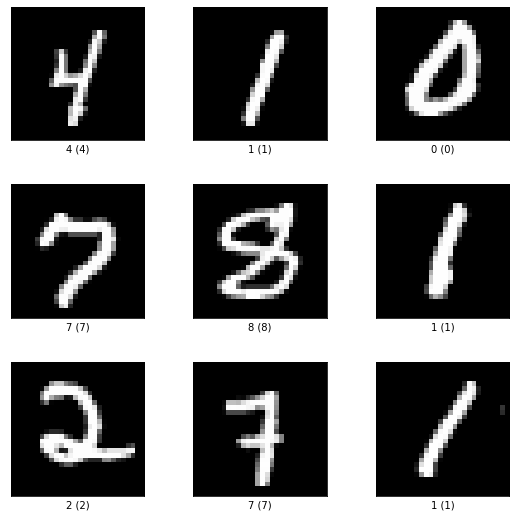

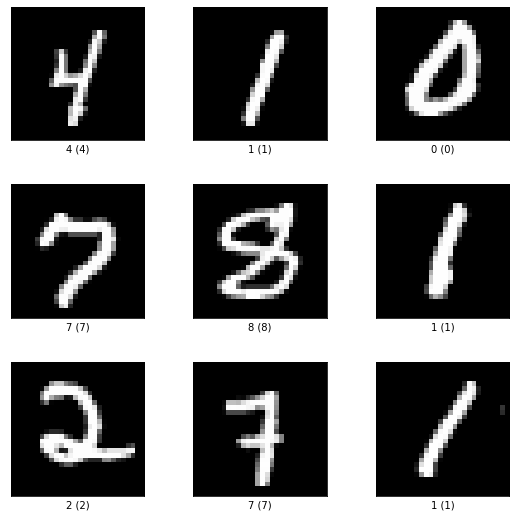

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

mnist, info = tfds.load('mnist', split='train', shuffle_files=True , with_info=True)
tfds.show_examples(info, mnist)

We can easily read off the shape of the input tensors that shows the images are all 28x28 pixels, but we do not yet know whether their greyscale values have been scaled to the [0, 1] range or not:

In [4]:
for example in mnist.take(1):
    squeezed = tf.squeeze(example["image"])
    print(tf.math.reduce_min(squeezed), tf.math.reduce_max(squeezed))

tf.Tensor(0, shape=(), dtype=uint8) tf.Tensor(255, shape=(), dtype=uint8)


No, they have not.
This means we have to do this in the training and before serving!

In [5]:
# Clear variables as we have no need for these any longer
del mnist, squeezed

In [6]:
epochs = 10

## How to Train the Model in the Notebook
We want to train the model in a distributed fashion, we put all the code in a single cell.
That way we can save the file and include it in a container image:

In [7]:
%%writefile $TRAINER_FILE
import argparse
import logging

import tensorflow as tf
import tensorflow_datasets as tfds

logging.getLogger().setLevel(logging.INFO)


def get_datasets(buffer_size):
    datasets, ds_info = tfds.load(name="mnist", data_dir="tensorflow_datasets", download=False, with_info=True, as_supervised=True)
    mnist_train, mnist_test = datasets["train"], datasets["test"]

    def scale(image, label):
        image = tf.cast(image, tf.float32) / 255
        return image, label

    train_dataset = mnist_train.map(scale).cache().shuffle(buffer_size).repeat()
    test_dataset = mnist_test.map(scale)

    return train_dataset, test_dataset


def compile_model(args):
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(32, 3, activation="relu", input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(10),
        ]
    )
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.SGD(
            learning_rate=args.learning_rate, momentum=args.momentum
        ),
        metrics=["accuracy"],
    )
    return model


def main():
    parser = argparse.ArgumentParser(description="TensorFlow MNIST Training Job")
    parser.add_argument(
        "--batch-size",
        type=int,
        default=64,
        metavar="N",
        help="Batch size for training (default: 64)",
    )
    parser.add_argument(
        "--buffer-size",
        type=int,
        default=10000,
        metavar="N",
        help="Number of training examples to buffer before shuffling" "default: 10000)",
    )
    parser.add_argument(
        "--epochs",
        type=int,
        default=5,
        metavar="N",
        help="Number of epochs to train (default: 5)",
    )
    parser.add_argument(
        "--steps",
        type=int,
        default=10,
        metavar="N",
        help="Number of batches to train the model on in each epoch (default: 10)",
    )
    parser.add_argument(
        "--learning-rate",
        type=float,
        default=0.5,
        metavar="N",
        help="Learning rate (default: 0.5)",
    )
    parser.add_argument(
        "--momentum",
        type=float,
        default=0.1,
        metavar="N",
        help="Accelerates SGD in the relevant direction and dampens oscillations (default: 0.1)",
    )

    args, _ = parser.parse_known_args()

    strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()
    logging.debug(f"num_replicas_in_sync: {strategy.num_replicas_in_sync}")
    global_batch_size = args.batch_size * strategy.num_replicas_in_sync

    # Datasets need to be created after instantiation of `MultiWorkerMirroredStrategy`
    train_dataset, test_dataset = get_datasets(buffer_size=args.buffer_size)
    train_dataset = train_dataset.batch(batch_size=global_batch_size)
    test_dataset = test_dataset.batch(batch_size=global_batch_size)

    # See: https://www.tensorflow.org/api_docs/python/tf/data/experimental/DistributeOptions
    dataset_options = tf.data.Options()
    dataset_options.experimental_distribute.auto_shard_policy = (
        tf.data.experimental.AutoShardPolicy.DATA
    )
    train_datasets_sharded = train_dataset.with_options(dataset_options)
    test_dataset_sharded = test_dataset.with_options(dataset_options)

    # Model compilation must be within `strategy.scope()`
    # See: https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras
    with strategy.scope():
        model = compile_model(args=args)

    # We cannot set `steps_per_epoch = None` with MirroredStrategy
    # See: https://github.com/tensorflow/tensorflow/issues/25254
    model.fit(train_datasets_sharded, epochs=args.epochs, steps_per_epoch=args.steps)
    eval_loss, eval_acc = model.evaluate(test_dataset_sharded, verbose=0, steps=args.steps)

    # Log metrics for Katib
    logging.info("loss={:.4f}".format(eval_loss))
    logging.info("accuracy={:.4f}".format(eval_acc))


if __name__ == "__main__":
    main()

Writing tf_mnist.py


That saves the file as defined by `TRAINER_FILE` but it does not run it.

Let's see if our code is correct by running it from within our notebook:

In [8]:
%run $TRAINER_FILE --epochs $epochs

INFO:tensorflow:Using MirroredStrategy with devices ('/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/device:CPU:0',)


INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CollectiveCommunication.AUTO


INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CollectiveCommunication.AUTO
INFO:absl:Load dataset info from tensorflow_datasets/mnist/3.0.1
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Constructing tf.data.Dataset for split None, from tensorflow_datasets/mnist/3.0.1


Train for 10 steps
Epoch 1/10
10/10 [==============================] - 9s 914ms/step - loss: 2.1250 - accuracy: 0.2609
Epoch 2/10
10/10 [==============================] - 1s 110ms/step - loss: 2.1401 - accuracy: 0.2984
Epoch 3/10
10/10 [==============================] - 1s 109ms/step - loss: 2.0543 - accuracy: 0.3781
Epoch 4/10
10/10 [==============================] - 1s 110ms/step - loss: 1.1721 - accuracy: 0.6344
Epoch 5/10
10/10 [==============================] - 1s 110ms/step - loss: 0.8289 - accuracy: 0.7781
Epoch 6/10
10/10 [==============================] - 1s 109ms/step - loss: 0.7386 - accuracy: 0.7609
Epoch 7/10
10/10 [==============================] - 1s 110ms/step - loss: 0.5666 - accuracy: 0.8094
Epoch 8/10
10/10 [==============================] - 1s 110ms/step - loss: 0.4122 - accuracy: 0.8703
Epoch 9/10
10/10 [==============================] - 1s 110ms/step - loss: 0.3536 - accuracy: 0.8797
Epoch 10/10
10/10 [==============================] - 1s 101ms/step - loss: 0.3819

INFO:root:loss=0.3786
INFO:root:accuracy=0.8797


## How to Create a Docker Image Manually


The Dockerfile looks as follows:

```
FROM mavencodev/tf_job:1.0
COPY tf_mnist.py /mnist.py
ADD tensorflow_datasets /datasets

ENTRYPOINT ["python", "-u", "/mnist.py"]
```

If GPU support is not needed, you can leave off the `-gpu` suffix from the image.
`mnist.py` is the trainer code you have to download to your local machine.

Then it's easy to push images to your container registry:

```bash
docker build -t <docker_image_name_with_tag> .
docker push <docker_image_name_with_tag>
```

The image is available as `mavencodev/tf_job:1.0` in case you want to skip it for now.

## How to Create a Distributed `TFJob`
For large training jobs, we wish to run our trainer in a distributed mode.
Once the notebook server cluster can access the Docker image from the registry, we can launch a distributed PyTorch job.

The specification for a distributed `TFJob` is defined using YAML:

In [9]:
%%writefile $KUBERNETES_FILE
apiVersion: "kubeflow.org/v1"
kind: "TFJob"
metadata:
  name: "tfjob-mnist"
spec:
  tfReplicaSpecs:
    Worker:
      replicas: 2
      restartPolicy: Never
      template:
        metadata:
          annotations:
            sidecar.istio.io/inject: "false"
        spec:
          containers:
            - name: tensorflow
              # modify this property if you would like to use a custom image
              image: mavencodev/tf_job:1.0
              args:
                - --epochs
                - "15"
                - --steps
                - "250"

Writing tfjob-mnist.yaml


Let's deploy the distributed training job:

In [10]:
%%capture tf_output --no-stderr
! kubectl create -f $KUBERNETES_FILE

In [11]:
TF_JOB = get_resource(tf_output)

To see the job status, use the following command:

In [12]:
! kubectl describe $TF_JOB

Name:         tfjob-mnist
Namespace:    demo01
Labels:       <none>
Annotations:  <none>
API Version:  kubeflow.org/v1
Kind:         TFJob
Metadata:
  Creation Timestamp:  2021-03-17T06:56:48Z
  Generation:          1
  Managed Fields:
    API Version:  kubeflow.org/v1
    Fields Type:  FieldsV1
    fieldsV1:
      f:spec:
        .:
        f:tfReplicaSpecs:
          .:
          f:Worker:
            .:
            f:replicas:
            f:restartPolicy:
            f:template:
              .:
              f:metadata:
                .:
                f:annotations:
                  .:
                  f:sidecar.istio.io/inject:
              f:spec:
    Manager:      kubectl-create
    Operation:    Update
    Time:         2021-03-17T06:56:48Z
    API Version:  kubeflow.org/v1
    Fields Type:  FieldsV1
    fieldsV1:
      f:spec:
        f:cleanPodPolicy:
        f:successPolicy:
        f:tfReplicaSpecs:
          f:Worker:
            f:template:
              f:metadata:

You should now be able to see the created pods matching the specified number of workers.

In [13]:
! kubectl get pods -l job-name=tfjob-mnist

NAME                   READY   STATUS              RESTARTS   AGE
tfjob-mnist-worker-0   0/1     ContainerCreating   0          3s
tfjob-mnist-worker-1   1/1     Running             0          3s


In case of issues, it may be helpful to see the last ten events within the cluster:

```bash
! kubectl get events --sort-by='.lastTimestamp' | tail
```

To stream logs from the worker-0 pod to check the training progress, run the following command:

In [14]:
! kubectl logs -f tfjob-mnist-worker-0

2021-03-17 06:56:54.018413: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2021-03-17 06:56:54.018443: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2021-03-17 06:56:54.018464: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tfjob-mnist-worker-0): /proc/driver/nvidia/version does not exist
2021-03-17 06:56:54.018723: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-03-17 06:56:54.027638: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2400080000 Hz
2021-03-17 06:56:54.027915: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f989c000b20 initializ

To delete the job, run the following command:

In [15]:
! kubectl delete $TF_JOB

tfjob.kubeflow.org "tfjob-mnist" deleted


Check to see if the check to see if the pod is still up and running 

In [ ]:
! kubectl -n demo01 logs -f tfjob-mnist